# Testing Sorting Algorithms Speed in C

In [1]:
from ctypes import cdll, CFUNCTYPE, POINTER, c_char_p, c_int, c_void_p, Structure
import os
import random
import string
import timeit

In [2]:
# Load My Library
lib_path = os.path.abspath("../build/liblcthw.so")
print(lib_path)
c_lib = cdll.LoadLibrary(lib_path)

# Function prototype
COMPARE_FUNC = CFUNCTYPE(c_int, c_char_p, c_char_p)

# Get `strcmp`
libc = cdll.LoadLibrary('libc.so.6')
strcmp = COMPARE_FUNC(libc.strcmp)

# List struct
class List(Structure):
    pass

List._fields_ = [
    ("count", c_int),
    ("first", POINTER(List)),
    ("last", POINTER(List)),
]

# List_create
c_lib.List_create.restype = POINTER(List)

# List_push
c_lib.List_push.argtypes = [POINTER(List), c_void_p]
c_lib.List_push.restype = None

# List_des
c_lib.List_destroy.argtypes = [POINTER(List)]
c_lib.List_destroy.restype = None


/home/user/code/learn/lchw/liblcthw/build/liblcthw.so


In [3]:
# Bubble sort
c_lib.List_bubble_sort.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_bubble_sort.restype = c_int

# Bubble sort optimized
c_lib.List_bubble_sort_opt.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_bubble_sort_opt.restype = c_int

# Merge sort
c_lib.List_merge_sort.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_merge_sort.restype = POINTER(List)

# Merge sort bottom up
c_lib.List_merge_sort_bottomup.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_merge_sort_bottomup.restype = POINTER(List)

# Quick sort
c_lib.List_quick_sort.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_quick_sort.restype = POINTER(List)

In [11]:
symbols = string.ascii_letters + string.digits

def get_random_c_str() -> bytes:
    length = random.randint(1, 30)
    return ("".join(random.choices(symbols, k=length))).encode('ascii')

def get_list_random_c_str(count: int) -> list[bytes]:
    return [get_random_c_str() for i in range(count)]

def create_random_c_list(count: int) -> POINTER:
    values = get_list_random_c_str(count)
    lst = c_lib.List_create()
    for v in values:
        c_lib.List_push(lst, c_char_p(v))        
    return lst

algo_list = {
    # "Bubble Sort": c_lib.List_bubble_sort,
    # "Bubble Sort Optimized": c_lib.List_bubble_sort_opt,
    "Merge Sort": c_lib.List_merge_sort,
    "Merge Sort Bottom Up": c_lib.List_merge_sort_bottomup,
    "Quick Sort": c_lib.List_quick_sort
}

def test_sorting_algorithms(start: int, step: int, max_elem: int) -> dict[str, tuple[list[int], list[int]]]:
    result = {k: ([], [],) for k in algo_list.keys()}
    for i in range(start, max_elem, step):
        values = get_list_random_c_str(i)
        for alg_name, alg in algo_list.items():
            lst = c_lib.List_create()
            for v in values:
                c_lib.List_push(lst, c_char_p(v))
            times = timeit.timeit(lambda: alg(lst, strcmp), number=1)
            result[alg_name][0].append(i)
            result[alg_name][1].append(times)
            # c_lib.List_destroy(lst)
    return result

In [15]:
x = test_sorting_algorithms(5000, 500, 10000)
# x = test_sorting_algorithms(500, 50, 1000)

In [16]:
x

{'Merge Sort': ([5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500],
  [0.018356962999860116,
   0.019717346000106772,
   0.02219642499994734,
   0.024018614999931742,
   0.02641316300014296,
   0.028004724999846076,
   0.029944439000246348,
   0.027903812999738875,
   0.029914450999967812,
   0.031596345999787445]),
 'Merge Sort Bottom Up': ([5000,
   5500,
   6000,
   6500,
   7000,
   7500,
   8000,
   8500,
   9000,
   9500],
  [0.009971628000130295,
   0.011047852000046987,
   0.012178167999991274,
   0.012995010000395268,
   0.014032890999715164,
   0.014893505000145524,
   0.015432037000209675,
   0.014792211999974825,
   0.016700777000096423,
   0.0168875209997168]),
 'Quick Sort': ([5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500],
  [0.020957160999842017,
   0.022883198999807064,
   0.027820674999929906,
   0.027061723999850074,
   0.03286011599993799,
   0.03616628400004629,
   0.03461156299999857,
   0.03404305200001545,
   0.036209085999871604,
   0.040

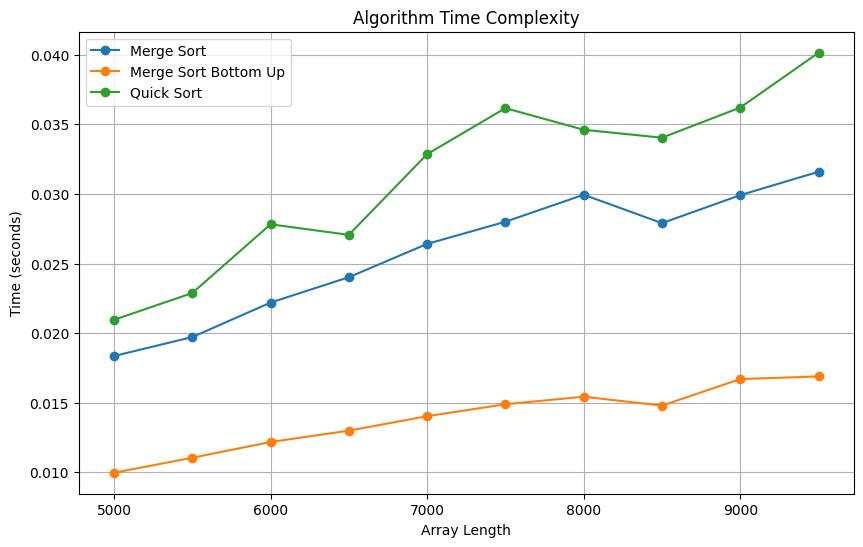

In [17]:
import matplotlib.pyplot as plt

type results = dict[str, tuple[list[int], list[int]]]
def plot_time_complexity(res: results, algorithm_name="Algorithm"):
    plt.figure(figsize=(10, 6))
    for k, v in res.items():
        plt.plot(v[0], v[1], marker='o', label=k)
    plt.xlabel('Array Length')
    plt.ylabel('Time (seconds)')
    plt.title(f'{algorithm_name} Time Complexity')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
plot_time_complexity(x)